Since demand is by region, one way to check is to sum the capacity of all transmission lines that END in the region and see if this sum is HIGHER than the maximum demand in a year.

RESULT: 
At the load region level, total line capacity far exceeds maximum region demand.

NEXT:
Check at the bus level: each bus in the case file was given a demand by the case creators; this bus demand is based on population that was used to generate the bus characteristics. 
So: for each bus, calculate the fraction of the demand that can be allocated to the bus, and check that total capacity for those lines connected to the bus is higher than the bus demand.

Pd is real power demand, assigned to the bus by population of clusters used to make synthetic bus.
* For each bus in region, assign a corresponding fraction of demand to this bus,e.g.,

* bus_demand = Pd(bus) * region_max_demand /sum_of_Pds_in_region

for each line connected to bus: 
* check if line capacity is large enough
* output if line is at risk

for each bus:
* check if total line capacity is enough for the max_bus_demand
* output if bus is at risk

In [1]:
from math import *
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, Polygon, MultiPolygon,MultiLineString
from bokeh.sampledata.us_counties import data as counties
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline


import westernintnet
WI = westernintnet.WesternIntNet()

Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Loading resources
Loading net_generation
Load solar data
Load wind data
Load hydro data
Load demand data
Done loading


In [4]:
br = WI.branches[['fbus','tbus','rateA']]
br = br.merge(WI.bus[['busID','area']], left_on = 'fbus', right_on = 'busID', how='left')
br.rename(columns = {'busID':'f_busID','area':'f_area'}, inplace=True)

br = br.merge(WI.bus[['busID','area']], left_on = 'tbus', right_on = 'busID', how='left')
br.rename(columns = {'busID':'t_busID','area':'t_area'}, inplace=True)

br.drop(columns = ['fbus','tbus'], inplace=True)

In [5]:
br.head()

,rateA,f_busID,f_area,t_busID,t_area
0,185.33,10002,1,10001,1
1,167.88,10011,1,10001,1
2,207.43,10014,1,10002,1
3,170.67,10004,1,10003,1
4,201.54,10003,1,10010,1


In [8]:
type(br.t_area[0])

numpy.int64

In [6]:
#area to demand mapping
WI.demand_data_2016.columns

Index(['Washington', 'Oregon', 'Northern California', 'Bay Area',
       'Central California', 'Southwest California', 'Southeast California',
       'Nevada', 'Arizona', 'Utah', 'New Mexico', 'Colorado', 'Wyoming',
       'Idaho', 'Montana', 'El Paso'],
      dtype='object')

In [9]:
load_regions = ['Washington', 'Oregon', 'Northern California', 'Bay Area',
       'Central California', 'Southwest California', 'Southeast California',
       'Nevada', 'Arizona', 'Utah', 'New Mexico', 'Colorado', 'Wyoming',
       'Idaho', 'Montana', 'El Paso']
area_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
print(len(load_regions))
print(len(area_num))

16
16


In [10]:
WI.demand_data_2016.describe()

,Washington,Oregon,Northern California,Bay Area,Central California,Southwest California,Southeast California,Nevada,Arizona,Utah,New Mexico,Colorado,Wyoming,Idaho,Montana,El Paso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,9577.067048,6407.425583,4175.545203,5402.610679,2823.021380,10857.845790,8971.947644,4148.422017,10866.974780,3046.670310,1101.942407,7509.732247,858.078925,3085.334701,1714.448692,234.598524
std,1592.682555,1060.619217,744.725536,988.021095,537.207333,2075.996816,1718.706294,1047.604833,2762.067378,423.856077,248.005160,1153.927677,110.012318,438.177110,231.648549,62.896107
min,6369.823319,4232.133898,2811.187977,3770.489617,1856.739981,7134.659643,6188.059544,2747.000000,6686.043117,1555.057243,360.785579,2955.115286,548.521415,2107.599396,1109.196855,0.000000
25%,8483.752686,5637.972439,3640.034714,4677.935712,2430.893301,9315.370227,7714.786430,3470.000000,8876.949281,2751.740305,931.687555,6736.373566,783.362758,2774.177635,1548.958623,190.156270
50%,9460.716479,6372.330284,4109.776987,5258.986731,2732.295099,10614.484638,8691.959092,3798.000000,9999.592504,3001.742134,1043.411708,7343.662943,844.189369,3034.954118,1699.207803,218.618370
75%,10515.224211,7067.802431,4562.563568,5821.037407,3041.798631,11750.307856,9690.097719,4436.000000,12077.449569,3264.358733,1200.658183,8078.226149,916.317084,3349.052559,1858.426253,260.084704
max,14994.678833,9871.664208,7275.399896,9449.846091,5039.747740,19426.169495,15954.551173,8525.000000,20897.867919,7164.616611,2031.505399,14633.472104,1630.120602,5431.386540,2503.464584,465.944202


In [22]:
WI.demand_data_2016.describe().loc['max']['Washington']

14994.67883267626

In [11]:
br.head()

,rateA,f_busID,f_area,t_busID,t_area
0,185.33,10002,1,10001,1
1,167.88,10011,1,10001,1
2,207.43,10014,1,10002,1
3,170.67,10004,1,10003,1
4,201.54,10003,1,10010,1


In [14]:
total_rateA = br.groupby('t_area')['rateA'].sum()

In [16]:
total_rateA[1]

605889.9199999997

In [17]:
total_rateA

t_area
1     605889.92
2     397583.24
3     281033.43
4     307194.92
5     212313.36
6     659254.97
7     503606.84
8     222559.51
9     661482.09
10    257966.66
11     90052.14
12    372178.33
13     66380.25
14    104842.64
15     90946.35
16     31733.24
Name: rateA, dtype: float64

In [52]:
#There must be a faster way to do this

sum_rateA = {}
max_demand = {}
colnames = ['sum_rateA','max_demand']

for x in zip(area_num,load_regions):
    #print(x[1], total_rateA[x[0]], WI.demand_data_2016.describe().loc['max'][x[1]], sep='\t')
    sum_rateA[x[1]] = total_rateA[x[0]]
    max_demand[x[1]] = WI.demand_data_2016.describe().loc['max'][x[1]]

ds = [sum_rateA, max_demand]
d = {}
for k in max_demand.keys():
    d[k] = tuple(d[k] for d in ds)
    
compare = pd.DataFrame.from_dict(d, orient='index', columns=colnames)
compare

,sum_rateA,max_demand
Washington,605889.92,14994.678833
Oregon,397583.24,9871.664208
Northern California,281033.43,7275.399896
Bay Area,307194.92,9449.846091
Central California,212313.36,5039.747740
Southwest California,659254.97,19426.169495
Southeast California,503606.84,15954.551173
Nevada,222559.51,8525.000000
Arizona,661482.09,20897.867919
Utah,257966.66,7164.616611


Looks like rateA satisfies demand at the region level scale.
Go to smaller scale level. 
This means going to BA-county level.
Or check demand per county per capita vs total incoming lines capacity per capita?

In [ ]:
One more check: compare rateA, rateB, rateC

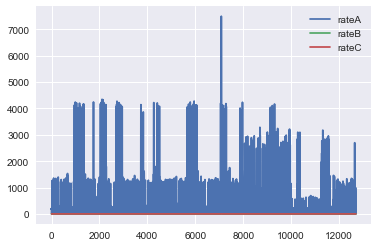

In [54]:
WI.branches[['rateA','rateB','rateC']].plot()

In [55]:
print(WI.branches['rateA'].max())
print(WI.branches['rateB'].max())
print(WI.branches['rateC'].max())

7500.0
0
0


No rateB, rateC data!

Check demand at bus level. 

In [56]:
WI.bus.head()

,busID,type,Pd,Qd,Gs,Bs,area,Vm,Va,baseKV,zone,Vmax,Vmin,lam_P,lam_Q,mu_Vmax,mu_Vmin,lat,lon
0,10001,1,9.64,2.54,0,0.0,1,1.011641,-39.843601,138.0,1,1.1,0.9,20.77,0.28,0.0,0.0000;,48.241400,-124.577777
1,10002,1,15.98,6.04,0,0.0,1,1.017025,-37.043319,138.0,1,1.1,0.9,20.47,0.29,0.0,0.0000;,47.695555,-124.183645
2,10003,1,14.39,1.09,0,0.0,1,1.031450,-34.039098,138.0,1,1.1,0.9,20.08,0.26,0.0,0.0000;,47.040041,-124.056969
3,10004,1,0.00,0.00,0,0.0,1,1.032459,-33.926182,138.0,1,1.1,0.9,20.06,0.26,0.0,0.0000;,46.927528,-124.171950
4,10005,1,10.45,2.75,0,0.0,1,1.032407,-33.932471,138.0,1,1.1,0.9,20.06,0.26,0.0,0.0000;,46.927528,-124.171950


Pd is real power demand, assigned to the bus by population of clusters used to make synthetic bus.
* For each bus in region, assign a corresponding fraction of demand to this bus,e.g.,

* bus_demand = Pd(bus) * region_max_demand /sum_of_Pds_in_region

for each line connected to bus: 
* check if line capacity is large enough
* output if line is at risk

for each bus:
* check if total line capacity is enough for the max_bus_demand
* output if bus is at risk

In [58]:
WI.read_sub??